In [1]:
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback

2025-01-10 04:07:01.067096: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736462221.096474  274893 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736462221.106728  274893 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-10 04:07:01.145302: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available: 1


In [3]:
tf.keras.backend.clear_session() 

In [4]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

In [5]:
np.random.seed(42)
tf.random.set_seed(42)

In [6]:
LOW_RES_PATH = "./LR/"
HIGH_RES_PATH = "./HR/"

In [7]:
EPOCHS = 50
BATCH_SIZE = 1
HR_SHAPE = (1024, 1024, 3)
LR_SHAPE = (256, 256, 3)
LEARNING_RATE = 1e-4

In [8]:
class RealTimePlottingCallback(Callback):
    def __init__(self):
        super().__init__()
        self.epochs = []
        self.losses = []
        self.psnrs = []
        self.ssims = []
        self.snrs = []

    def on_epoch_end(self, epoch, logs=None):
        self.epochs.append(epoch)
        self.losses.append(logs['loss'])
        
        # Add the values for PSNR, SSIM, and SNR (modify these based on your metrics' names)
        if 'psnr' in logs:
            self.psnrs.append(logs['psnr'])
        else:
            self.psnrs.append(None)
        
        if 'ssim' in logs:
            self.ssims.append(logs['ssim'])
        else:
            self.ssims.append(None)
        
        if 'snr' in logs:
            self.snrs.append(logs['snr'])
        else:
            self.snrs.append(None)

        # Clear the plot and re-draw for each epoch
        plt.clf()
        
        # Plotting Loss
        plt.subplot(2, 2, 1)
        plt.plot(self.epochs, self.losses, label='Loss', color='red')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss')

        # Plotting PSNR
        if self.psnrs[0] is not None:
            plt.subplot(2, 2, 2)
            plt.plot(self.epochs, self.psnrs, label='PSNR', color='blue')
            plt.xlabel('Epoch')
            plt.ylabel('PSNR')
            plt.title('PSNR')

        # Plotting SSIM
        if self.ssims[0] is not None:
            plt.subplot(2, 2, 3)
            plt.plot(self.epochs, self.ssims, label='SSIM', color='green')
            plt.xlabel('Epoch')
            plt.ylabel('SSIM')
            plt.title('SSIM')

        # Plotting SNR
        if self.snrs[0] is not None:
            plt.subplot(2, 2, 4)
            plt.plot(self.epochs, self.snrs, label='SNR', color='purple')
            plt.xlabel('Epoch')
            plt.ylabel('SNR')
            plt.title('SNR')

        # Adjust the layout and show the plot
        plt.tight_layout()
        plt.pause(0.1)

In [9]:
class PSNR(tf.keras.metrics.Metric):
    def __init__(self, name='psnr', **kwargs):
        super(PSNR, self).__init__(name=name, **kwargs)
        self.psnr_value = self.add_weight(name='psnr_value', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        max_pixel = 1.0
        psnr_value = tf.image.psnr(y_true, y_pred, max_val=max_pixel)
        self.psnr_value.assign(tf.reduce_mean(psnr_value))  # Update the state variable

    def result(self):
        return self.psnr_value

In [10]:
class SSIM(tf.keras.metrics.Metric):
    def __init__(self, name='ssim', **kwargs):
        super(SSIM, self).__init__(name=name, **kwargs)
        self.ssim_value = self.add_weight(name='ssim_value', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        ssim_value = tf.image.ssim(y_true, y_pred, max_val=1.0)
        self.ssim_value.assign(tf.reduce_mean(ssim_value))  # Update the state variable

    def result(self):
        return self.ssim_value

In [11]:
class SignalNoiseRatio(tf.keras.metrics.Metric):
    def __init__(self, name='snr', **kwargs):
        super(SignalNoiseRatio, self).__init__(name=name, **kwargs)
        self.snr_value = self.add_weight(name='snr_value', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        noise = tf.math.reduce_std(y_true - y_pred, axis=[1, 2])
        signal = tf.math.reduce_std(y_true, axis=[1, 2])
        snr_value = signal / noise
        self.snr_value.assign(tf.reduce_mean(snr_value))  # Update the state variable

    def result(self):
        return self.snr_value



In [12]:
def mse_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

In [13]:
def preprocess_image(image_path, target_size):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, target_size)
    image = tf.cast(image, tf.float32) / 127.5 - 1.0  # Normalize to [-1, 1]
    return image

In [14]:
def load_dataset(lr_path, hr_path, lr_shape, hr_shape, batch_size):
    lr_files = tf.data.Dataset.list_files(os.path.join(lr_path, "*.png"), shuffle=True)
    hr_files = tf.data.Dataset.list_files(os.path.join(hr_path, "*.png"), shuffle=True)

    lr_images = lr_files.map(
        lambda x: preprocess_image(x, lr_shape[:2]), num_parallel_calls=tf.data.AUTOTUNE
    )
    hr_images = hr_files.map(
        lambda x: preprocess_image(x, hr_shape[:2]), num_parallel_calls=tf.data.AUTOTUNE
    )

    dataset = tf.data.Dataset.zip((lr_images, hr_images))
    dataset = dataset.shuffle(buffer_size=256)  # Reduce shuffle buffer
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)  # Prefetch for performance
    return dataset

In [15]:
def split_dataset(dataset, val_size=0.2):
    total_size = len(dataset)
    val_size = int(total_size * val_size)
    train_size = total_size - val_size

    # Split the dataset
    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size)

    return train_dataset, val_dataset

In [16]:
checkpoint_callback = ModelCheckpoint(
    'super_resolution_model.weights.h5',
    monitor='val_psnr',
    mode='max',
    save_best_only=True,
    save_weights_only=True
)

early_stopping_callback = EarlyStopping(
    monitor='val_psnr',
    mode='max',
    patience=3,
    verbose=True,
    min_delta=0.1
)

In [17]:
dataset = load_dataset(LOW_RES_PATH, HIGH_RES_PATH, LR_SHAPE, HR_SHAPE, BATCH_SIZE)

I0000 00:00:1736462224.882743  274893 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2285 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [18]:
model = tf.keras.models.load_model('./super_resolution_model.weights.keras', custom_objects={'PSNR': PSNR, 'SSIM': SSIM, 'SignalNoiseRatio': SignalNoiseRatio, 'mse_loss': mse_loss})

/home/ragnar/.local/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 26 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/ragnar/.local/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [19]:
img = preprocess_image("./LR1/0006.png",(256,256))

In [20]:
img = np.expand_dims(img, axis=0)

In [21]:
res = model.predict(img)

I0000 00:00:1736462228.730001  275099 service.cc:148] XLA service 0x77933c006630 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736462228.730067  275099 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-01-10 04:07:08.743102: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736462228.768871  275099 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1736462230.450364  275099 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1736462230.598684  275099 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1736462231.741

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


I0000 00:00:1736462233.763939  275099 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


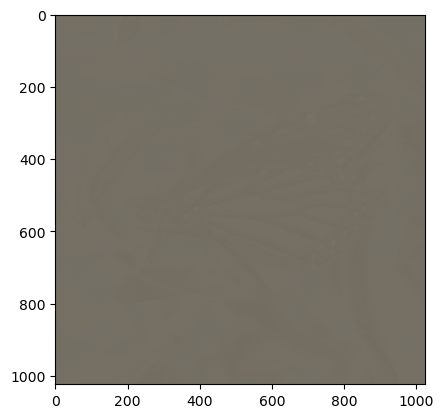

In [22]:
res+=1.0
res/=2
plt.imshow(res[0])

In [23]:
train_data, val_data = split_dataset(dataset)

In [24]:
realtime_plotting_callback = RealTimePlottingCallback()

Epoch 1/50


W0000 00:00:1736462243.136338  275099 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1736462243.136545  275099 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert
W0000 00:00:1736462243.139718  275099 assert_op.cc:38] Ignoring Assert operator SSIM/Assert/Assert
W0000 00:00:1736462243.140155  275099 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_1/Assert
W0000 00:00:1736462243.140584  275099 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_2/Assert
W0000 00:00:1736462243.140854  275099 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_3/Assert
E0000 00:00:1736462244.159137  275099 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1736462244.305329  275099 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.3037 - psnr: 5.4589 - snr: 1.0009 - ssim: 0.0074

W0000 00:00:1736462594.567764  275099 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1736462594.568003  275099 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert
W0000 00:00:1736462594.581754  275099 assert_op.cc:38] Ignoring Assert operator SSIM/Assert/Assert
W0000 00:00:1736462594.581821  275099 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_1/Assert
W0000 00:00:1736462594.582111  275099 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_2/Assert
W0000 00:00:1736462594.582328  275099 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_3/Assert


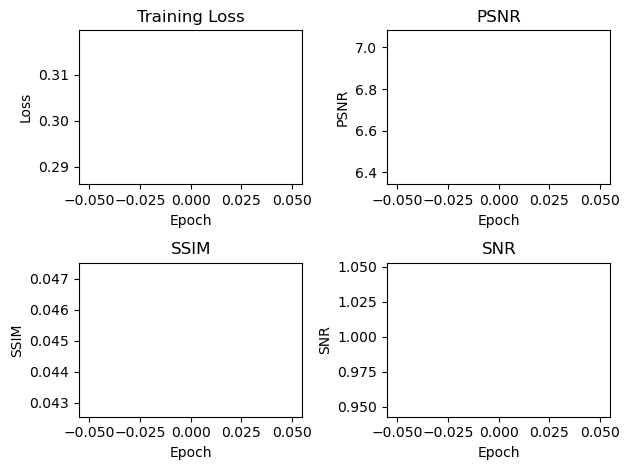

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 388s 128ms/step - loss: 0.3037 - psnr: 5.4594 - snr: 1.0009 - ssim: 0.0074 - val_loss: 0.3015 - val_psnr: 5.3363 - val_snr: 1.0078 - val_ssim: 0.0420
Epoch 2/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.3040 - psnr: 5.4694 - snr: 1.0012 - ssim: 0.0079

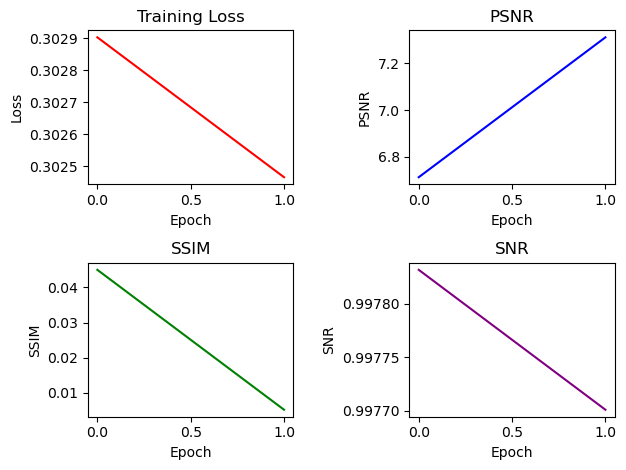

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 362s 125ms/step - loss: 0.3040 - psnr: 5.4700 - snr: 1.0012 - ssim: 0.0079 - val_loss: 0.3001 - val_psnr: 4.3362 - val_snr: 0.9971 - val_ssim: 0.1729
Epoch 3/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.3028 - psnr: 5.4628 - snr: 1.0011 - ssim: 0.0044

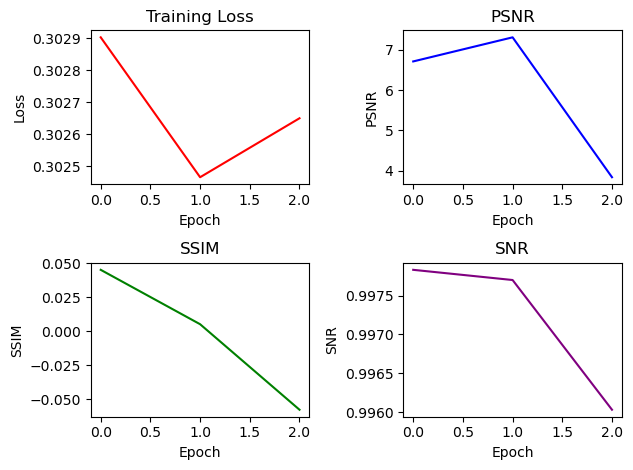

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 364s 125ms/step - loss: 0.3028 - psnr: 5.4622 - snr: 1.0011 - ssim: 0.0044 - val_loss: 0.3046 - val_psnr: 5.0366 - val_snr: 1.0041 - val_ssim: 0.0362
Epoch 4/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.3029 - psnr: 5.4692 - snr: 1.0015 - ssim: 0.0086

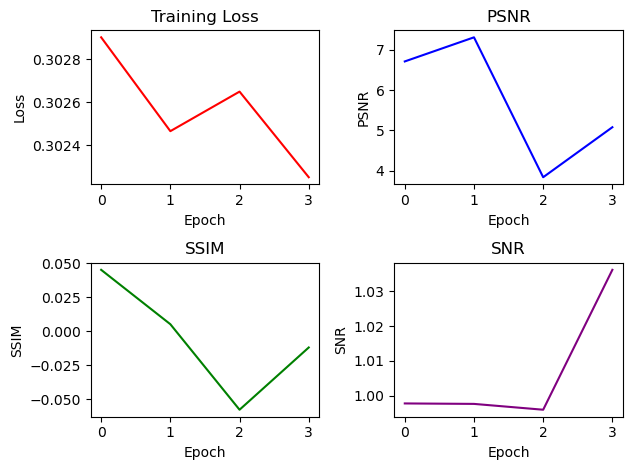

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 365s 126ms/step - loss: 0.3029 - psnr: 5.4691 - snr: 1.0015 - ssim: 0.0086 - val_loss: 0.3004 - val_psnr: 4.4687 - val_snr: 1.0012 - val_ssim: -0.1133
Epoch 5/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.3029 - psnr: 5.4796 - snr: 1.0009 - ssim: 0.0061

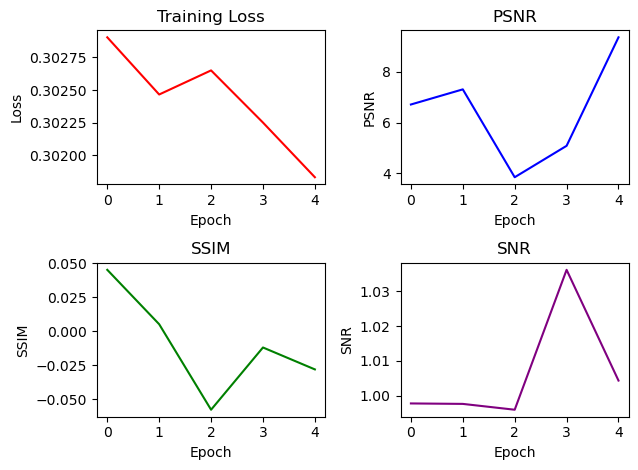

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 365s 126ms/step - loss: 0.3029 - psnr: 5.4810 - snr: 1.0009 - ssim: 0.0061 - val_loss: 0.3007 - val_psnr: 6.3489 - val_snr: 0.9987 - val_ssim: 0.0128
Epoch 6/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.3010 - psnr: 5.4625 - snr: 1.0014 - ssim: 0.0070

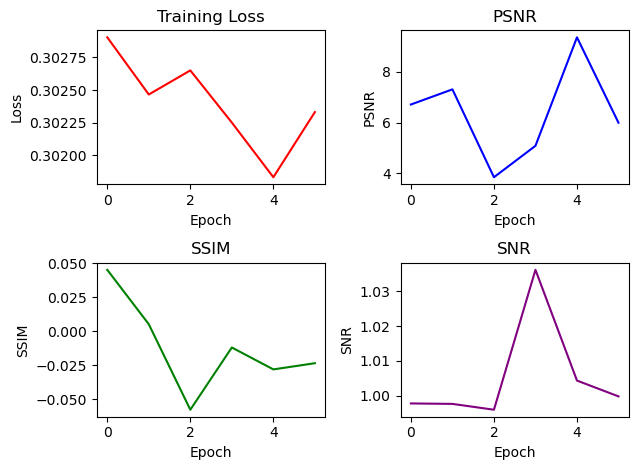

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 364s 126ms/step - loss: 0.3010 - psnr: 5.4627 - snr: 1.0014 - ssim: 0.0070 - val_loss: 0.2999 - val_psnr: 6.0805 - val_snr: 1.0123 - val_ssim: -0.0488
Epoch 7/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.3026 - psnr: 5.4647 - snr: 1.0014 - ssim: 0.0062

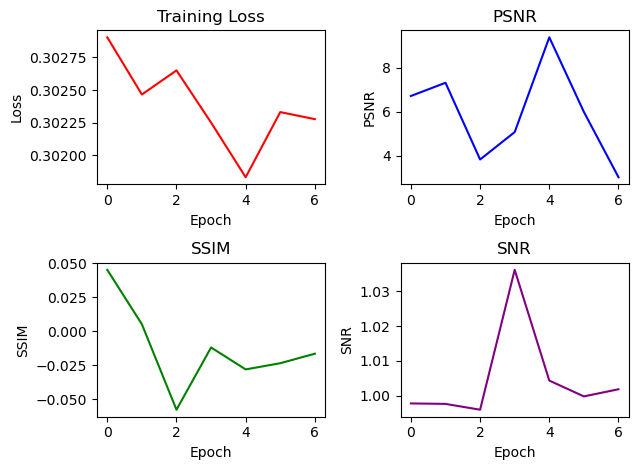

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 364s 125ms/step - loss: 0.3026 - psnr: 5.4639 - snr: 1.0014 - ssim: 0.0062 - val_loss: 0.3008 - val_psnr: 5.8737 - val_snr: 1.0012 - val_ssim: 0.0050
Epoch 8/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.3016 - psnr: 5.4907 - snr: 1.0011 - ssim: 0.0075

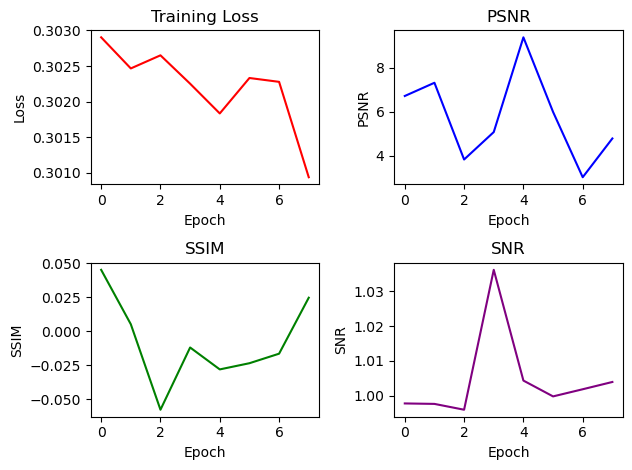

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 373s 129ms/step - loss: 0.3016 - psnr: 5.4905 - snr: 1.0011 - ssim: 0.0075 - val_loss: 0.3068 - val_psnr: 9.7321 - val_snr: 0.9966 - val_ssim: 0.0991
Epoch 9/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.2995 - psnr: 5.4939 - snr: 1.0013 - ssim: 0.0083

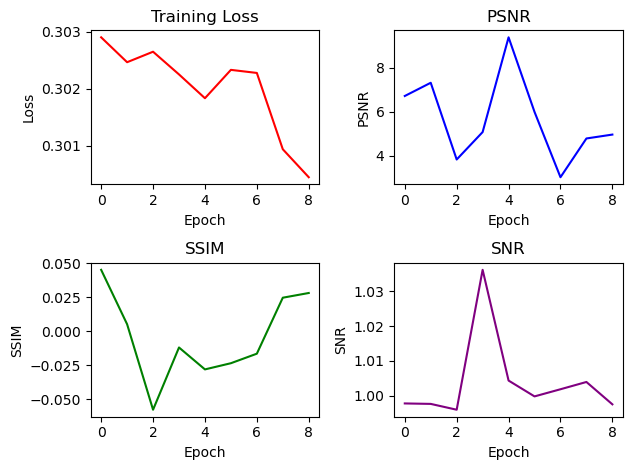

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 365s 126ms/step - loss: 0.2995 - psnr: 5.4937 - snr: 1.0013 - ssim: 0.0083 - val_loss: 0.3036 - val_psnr: 7.6759 - val_snr: 1.0289 - val_ssim: -0.1128
Epoch 10/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.3002 - psnr: 5.4820 - snr: 1.0012 - ssim: 0.0065

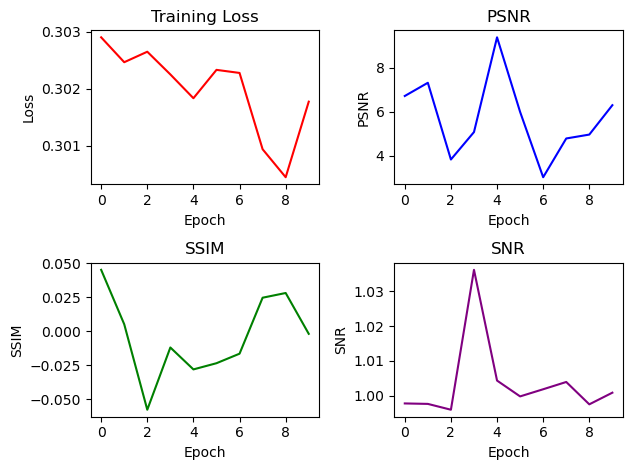

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 365s 126ms/step - loss: 0.3002 - psnr: 5.4823 - snr: 1.0012 - ssim: 0.0065 - val_loss: 0.3052 - val_psnr: 2.5750 - val_snr: 1.0052 - val_ssim: -0.1192
Epoch 11/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.3023 - psnr: 5.4747 - snr: 1.0012 - ssim: 0.0078

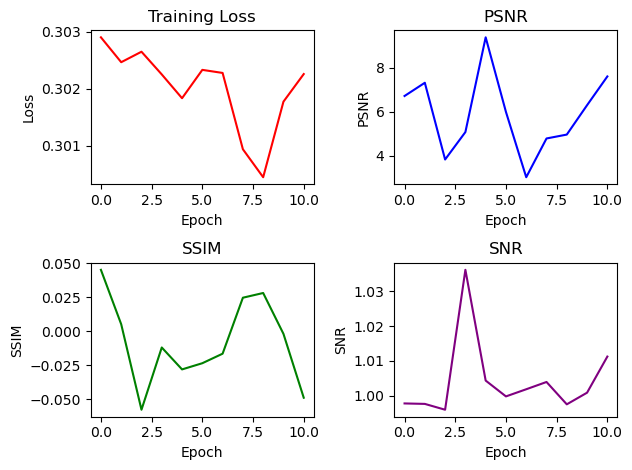

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 365s 126ms/step - loss: 0.3023 - psnr: 5.4755 - snr: 1.0012 - ssim: 0.0077 - val_loss: 0.3016 - val_psnr: 5.4815 - val_snr: 0.9991 - val_ssim: 0.0241
Epoch 12/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.3016 - psnr: 5.4841 - snr: 1.0013 - ssim: 0.0083

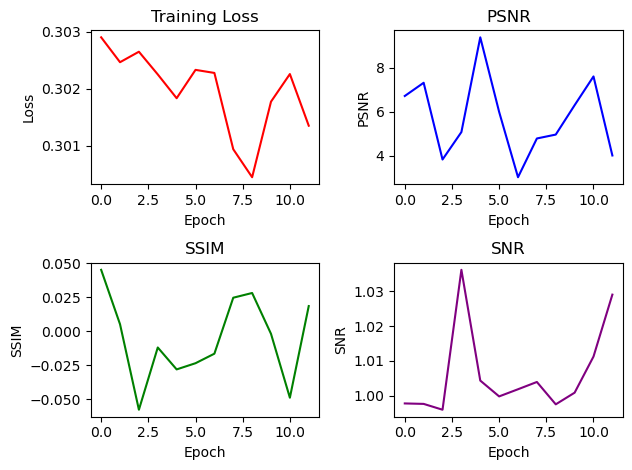

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 363s 125ms/step - loss: 0.3016 - psnr: 5.4836 - snr: 1.0013 - ssim: 0.0083 - val_loss: 0.3080 - val_psnr: 6.4194 - val_snr: 1.0047 - val_ssim: 0.0478
Epoch 13/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.3048 - psnr: 5.4683 - snr: 1.0011 - ssim: 0.0073

2025-01-10 05:25:02.178195: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 13369344 bytes after encountering the first element of size 13369344 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-01-10 05:26:10.257386: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 13369344 bytes after encountering the first element of size 13369344 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


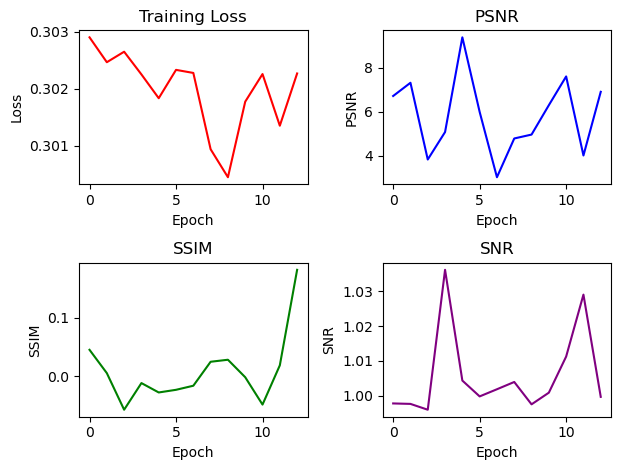

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 361s 124ms/step - loss: 0.3048 - psnr: 5.4688 - snr: 1.0011 - ssim: 0.0074 - val_loss: 0.3012 - val_psnr: 5.2275 - val_snr: 1.0004 - val_ssim: -0.0401
Epoch 14/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.2989 - psnr: 5.4806 - snr: 1.0014 - ssim: 0.0072

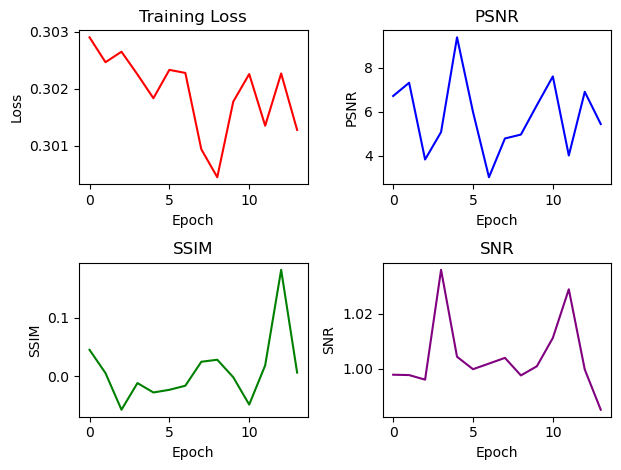

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 360s 124ms/step - loss: 0.2989 - psnr: 5.4806 - snr: 1.0014 - ssim: 0.0072 - val_loss: 0.2991 - val_psnr: 4.1977 - val_snr: 1.0045 - val_ssim: -0.0856
Epoch 15/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.3005 - psnr: 5.4770 - snr: 1.0013 - ssim: 0.0065

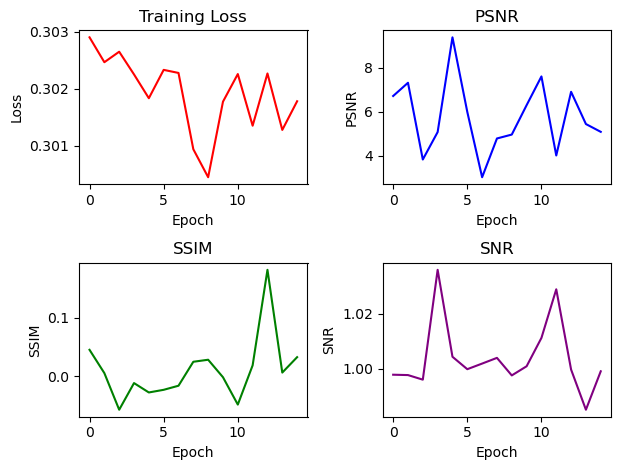

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 358s 123ms/step - loss: 0.3005 - psnr: 5.4769 - snr: 1.0013 - ssim: 0.0065 - val_loss: 0.3055 - val_psnr: 5.5007 - val_snr: 0.9945 - val_ssim: -0.0349
Epoch 16/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.3005 - psnr: 5.4584 - snr: 1.0013 - ssim: 0.0075

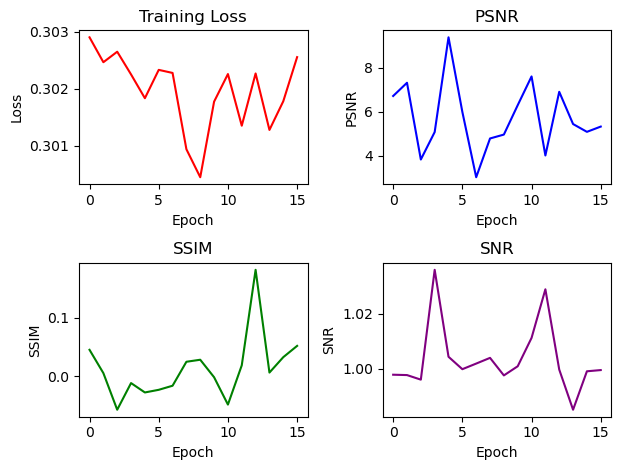

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 360s 124ms/step - loss: 0.3005 - psnr: 5.4583 - snr: 1.0013 - ssim: 0.0075 - val_loss: 0.3056 - val_psnr: 5.9597 - val_snr: 0.9970 - val_ssim: 0.0912
Epoch 17/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.3008 - psnr: 5.4786 - snr: 1.0014 - ssim: 0.0075

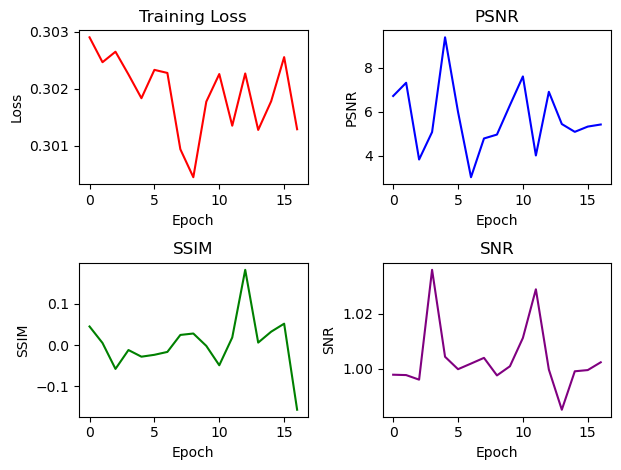

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 359s 124ms/step - loss: 0.3008 - psnr: 5.4786 - snr: 1.0014 - ssim: 0.0074 - val_loss: 0.2997 - val_psnr: 5.4052 - val_snr: 0.9988 - val_ssim: -0.0161
Epoch 18/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.3046 - psnr: 5.4419 - snr: 1.0013 - ssim: 0.0076

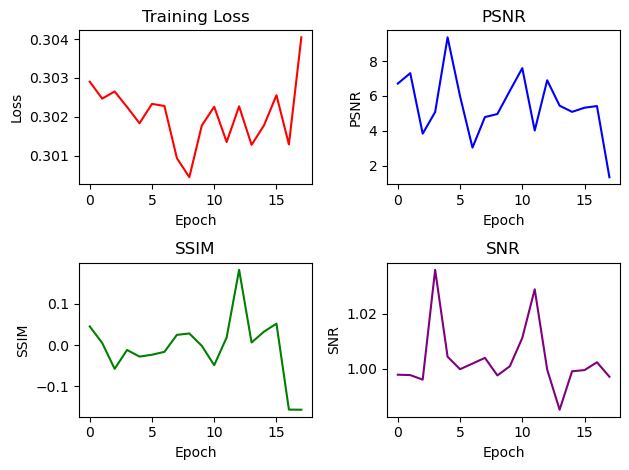

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 360s 124ms/step - loss: 0.3046 - psnr: 5.4404 - snr: 1.0013 - ssim: 0.0076 - val_loss: 0.2951 - val_psnr: 5.6086 - val_snr: 1.0070 - val_ssim: -0.0258
Epoch 19/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.3024 - psnr: 5.4817 - snr: 1.0013 - ssim: 0.0074

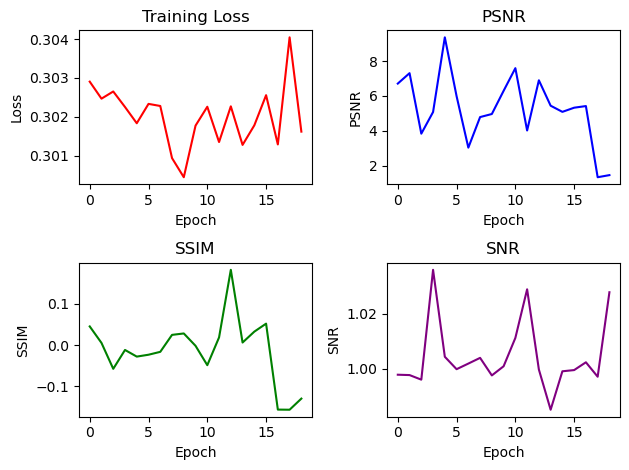

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 362s 125ms/step - loss: 0.3024 - psnr: 5.4803 - snr: 1.0013 - ssim: 0.0073 - val_loss: 0.3006 - val_psnr: 6.8173 - val_snr: 1.0032 - val_ssim: 0.0135
Epoch 20/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.3031 - psnr: 5.4580 - snr: 1.0016 - ssim: 0.0063

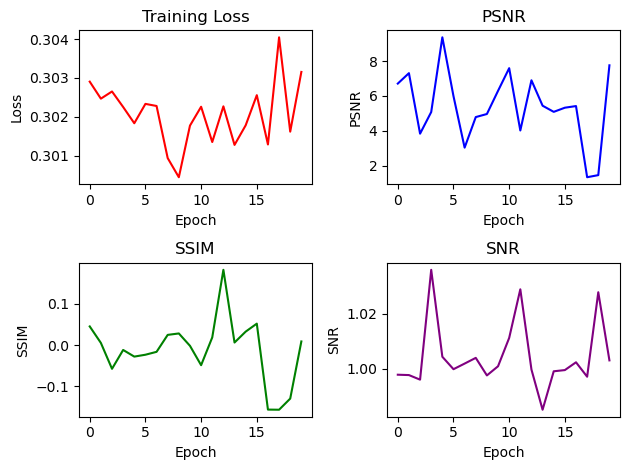

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 362s 125ms/step - loss: 0.3031 - psnr: 5.4588 - snr: 1.0016 - ssim: 0.0063 - val_loss: 0.3075 - val_psnr: 4.9155 - val_snr: 1.0001 - val_ssim: 0.1010
Epoch 21/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.3043 - psnr: 5.4678 - snr: 1.0014 - ssim: 0.0068

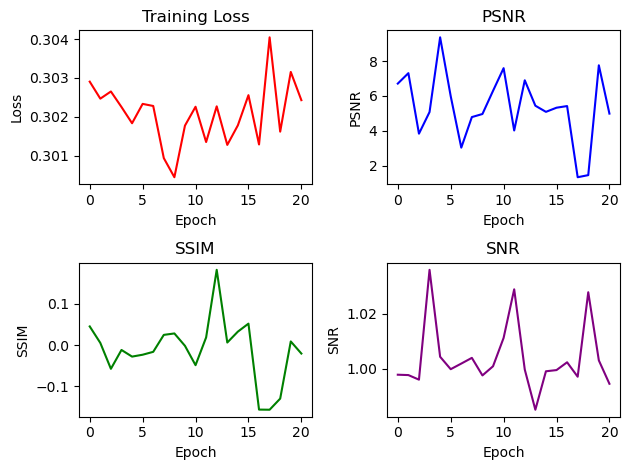

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 361s 125ms/step - loss: 0.3043 - psnr: 5.4677 - snr: 1.0014 - ssim: 0.0068 - val_loss: 0.2970 - val_psnr: 3.7535 - val_snr: 0.9869 - val_ssim: 0.0807
Epoch 22/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.2982 - psnr: 5.4713 - snr: 1.0015 - ssim: 0.0075

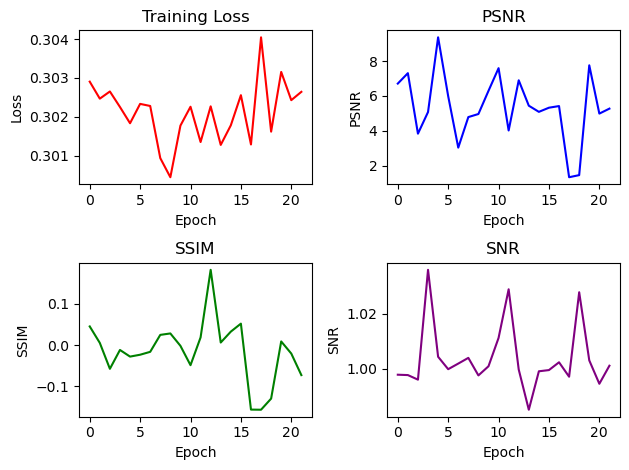

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 363s 125ms/step - loss: 0.2982 - psnr: 5.4712 - snr: 1.0015 - ssim: 0.0075 - val_loss: 0.3030 - val_psnr: 5.5691 - val_snr: 0.9954 - val_ssim: 0.1311
Epoch 23/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.3020 - psnr: 5.4900 - snr: 1.0012 - ssim: 0.0075

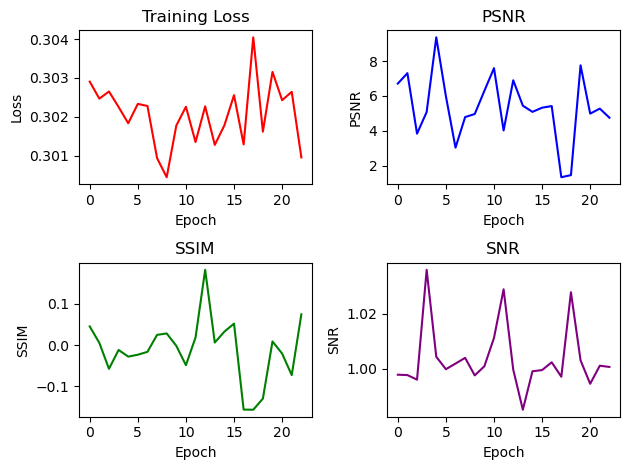

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 361s 124ms/step - loss: 0.3020 - psnr: 5.4898 - snr: 1.0012 - ssim: 0.0075 - val_loss: 0.3052 - val_psnr: 2.7670 - val_snr: 1.0120 - val_ssim: -0.0024
Epoch 24/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.3031 - psnr: 5.4752 - snr: 1.0017 - ssim: 0.0068

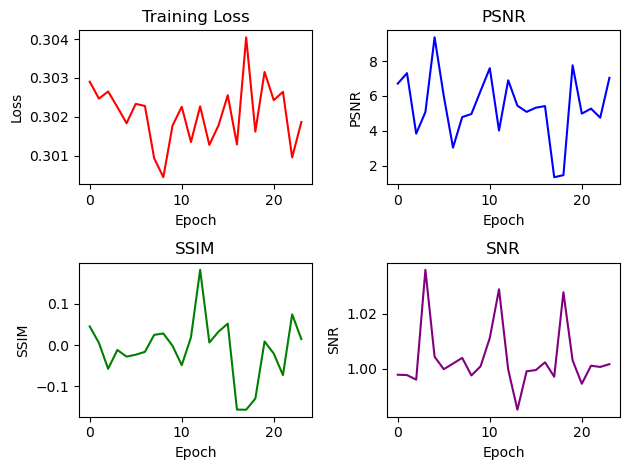

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 361s 125ms/step - loss: 0.3031 - psnr: 5.4757 - snr: 1.0017 - ssim: 0.0068 - val_loss: 0.3070 - val_psnr: 4.2615 - val_snr: 1.0006 - val_ssim: 5.2681e-04
Epoch 25/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.3038 - psnr: 5.4646 - snr: 1.0015 - ssim: 0.0071

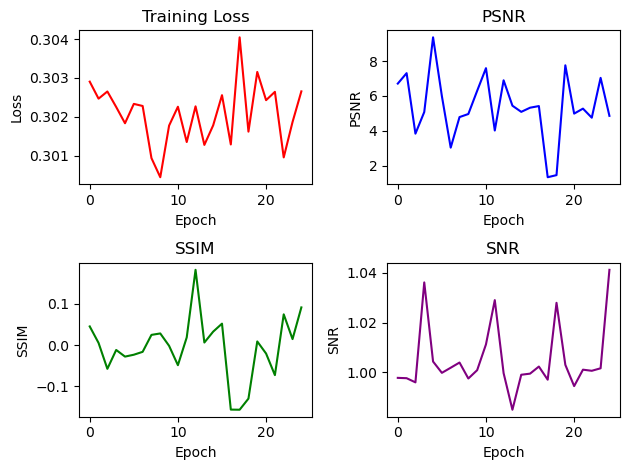

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 361s 124ms/step - loss: 0.3038 - psnr: 5.4644 - snr: 1.0016 - ssim: 0.0071 - val_loss: 0.3034 - val_psnr: 6.7982 - val_snr: 1.0231 - val_ssim: 0.0224
Epoch 26/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.3004 - psnr: 5.4755 - snr: 1.0011 - ssim: 0.0068

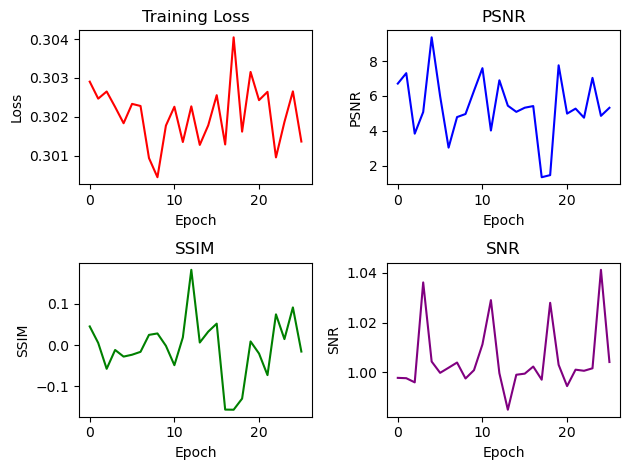

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 363s 125ms/step - loss: 0.3004 - psnr: 5.4754 - snr: 1.0011 - ssim: 0.0067 - val_loss: 0.3042 - val_psnr: 3.7733 - val_snr: 1.0025 - val_ssim: 0.0514
Epoch 27/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.3027 - psnr: 5.4683 - snr: 1.0013 - ssim: 0.0053

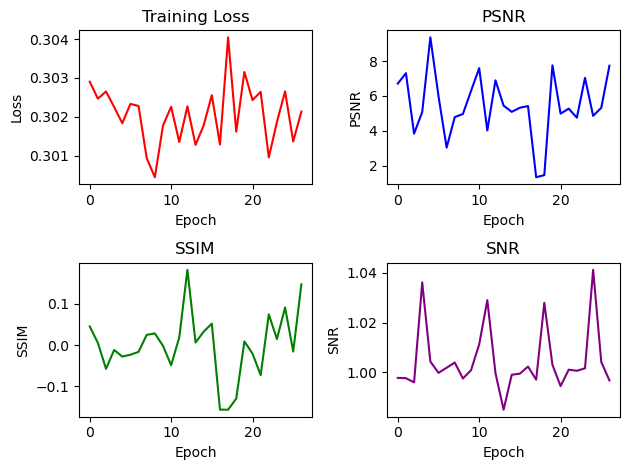

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 360s 124ms/step - loss: 0.3027 - psnr: 5.4691 - snr: 1.0013 - ssim: 0.0053 - val_loss: 0.2957 - val_psnr: 2.3408 - val_snr: 1.0029 - val_ssim: -0.0698
Epoch 28/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.3028 - psnr: 5.4603 - snr: 1.0015 - ssim: 0.0064

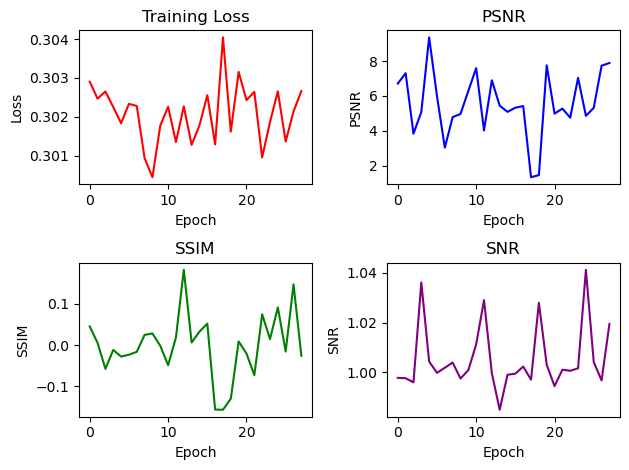

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 360s 124ms/step - loss: 0.3028 - psnr: 5.4612 - snr: 1.0015 - ssim: 0.0064 - val_loss: 0.3002 - val_psnr: 4.4786 - val_snr: 0.9989 - val_ssim: 0.1864
Epoch 29/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.3011 - psnr: 5.4565 - snr: 1.0016 - ssim: 0.0073

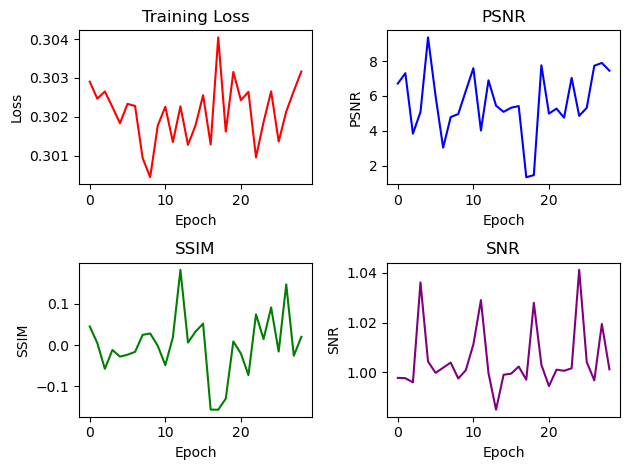

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 360s 124ms/step - loss: 0.3011 - psnr: 5.4572 - snr: 1.0016 - ssim: 0.0073 - val_loss: 0.2975 - val_psnr: 5.5127 - val_snr: 1.0249 - val_ssim: 0.0102
Epoch 30/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.3049 - psnr: 5.4711 - snr: 1.0018 - ssim: 0.0072

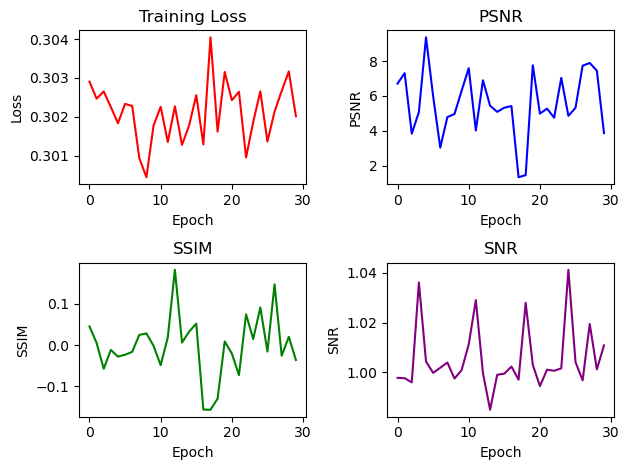

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 362s 125ms/step - loss: 0.3049 - psnr: 5.4706 - snr: 1.0018 - ssim: 0.0072 - val_loss: 0.3075 - val_psnr: 6.5564 - val_snr: 0.9976 - val_ssim: -0.0080
Epoch 31/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.3025 - psnr: 5.4667 - snr: 1.0014 - ssim: 0.0081

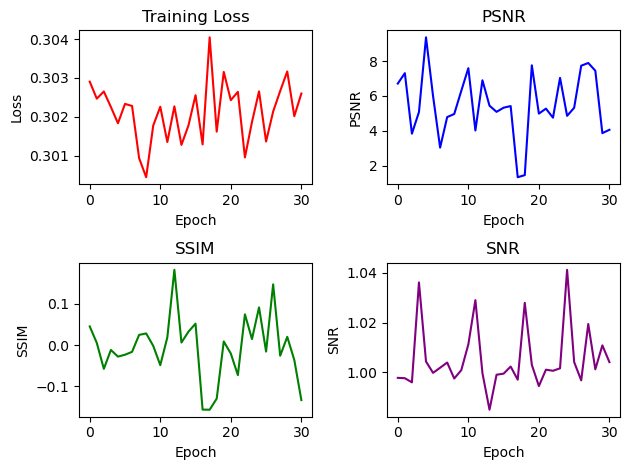

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 366s 126ms/step - loss: 0.3025 - psnr: 5.4662 - snr: 1.0014 - ssim: 0.0080 - val_loss: 0.3002 - val_psnr: 4.7547 - val_snr: 1.0069 - val_ssim: 0.0120
Epoch 32/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.3024 - psnr: 5.4682 - snr: 1.0013 - ssim: 0.0071

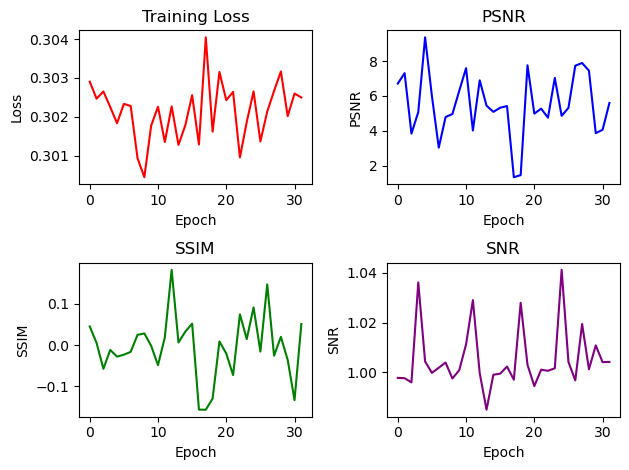

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 363s 125ms/step - loss: 0.3024 - psnr: 5.4683 - snr: 1.0013 - ssim: 0.0071 - val_loss: 0.3007 - val_psnr: 4.4532 - val_snr: 0.9946 - val_ssim: 0.0062
Epoch 33/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.3011 - psnr: 5.4949 - snr: 1.0014 - ssim: 0.0081

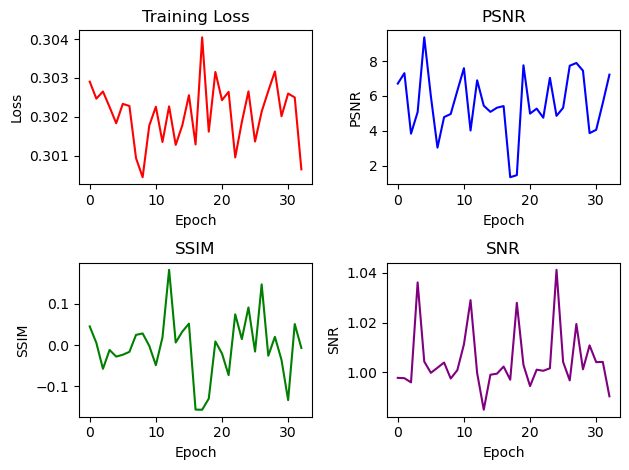

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 361s 125ms/step - loss: 0.3011 - psnr: 5.4956 - snr: 1.0014 - ssim: 0.0081 - val_loss: 0.3014 - val_psnr: 5.2044 - val_snr: 1.0105 - val_ssim: -0.0811
Epoch 34/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.3058 - psnr: 5.4688 - snr: 1.0014 - ssim: 0.0077

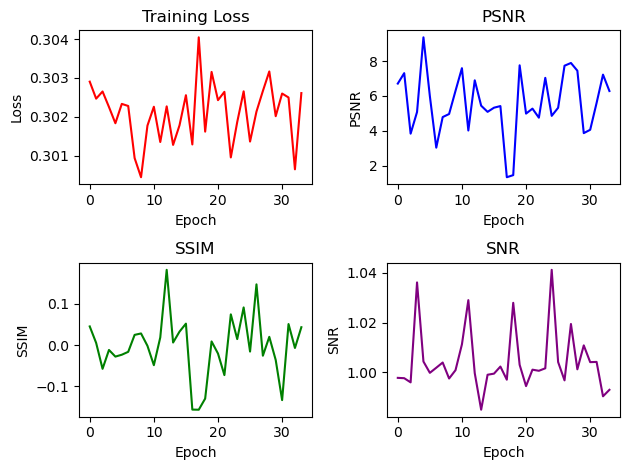

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 364s 125ms/step - loss: 0.3058 - psnr: 5.4691 - snr: 1.0014 - ssim: 0.0077 - val_loss: 0.3021 - val_psnr: 4.3967 - val_snr: 0.9978 - val_ssim: 0.1713
Epoch 35/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.3025 - psnr: 5.4588 - snr: 1.0015 - ssim: 0.0068

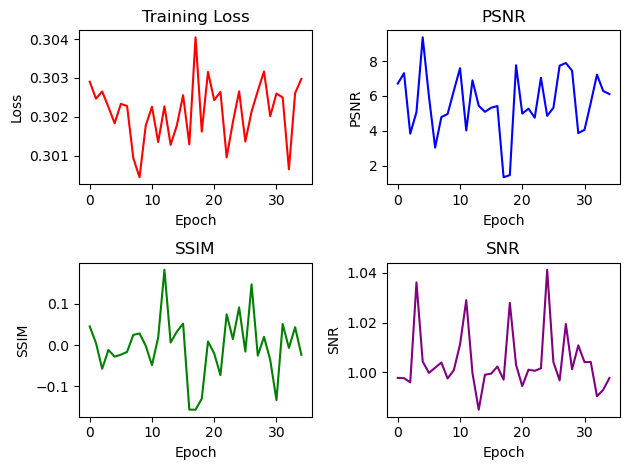

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 362s 124ms/step - loss: 0.3025 - psnr: 5.4590 - snr: 1.0014 - ssim: 0.0067 - val_loss: 0.2969 - val_psnr: 3.7096 - val_snr: 1.0025 - val_ssim: 3.2808e-04
Epoch 36/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.3017 - psnr: 5.4628 - snr: 1.0015 - ssim: 0.0074

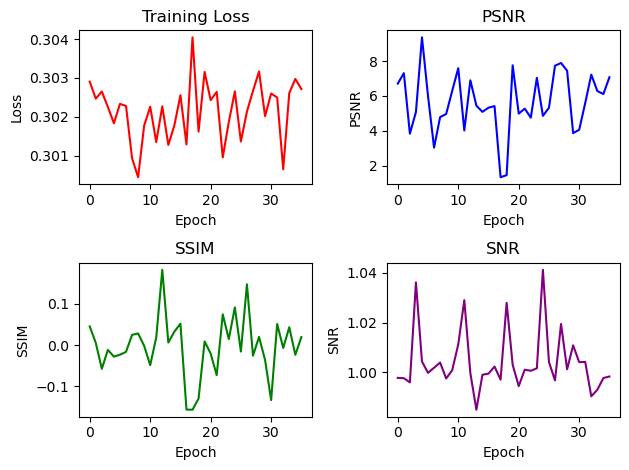

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 361s 124ms/step - loss: 0.3017 - psnr: 5.4634 - snr: 1.0015 - ssim: 0.0074 - val_loss: 0.3000 - val_psnr: 6.0650 - val_snr: 0.9990 - val_ssim: -0.0612
Epoch 37/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.3022 - psnr: 5.5030 - snr: 1.0016 - ssim: 0.0069

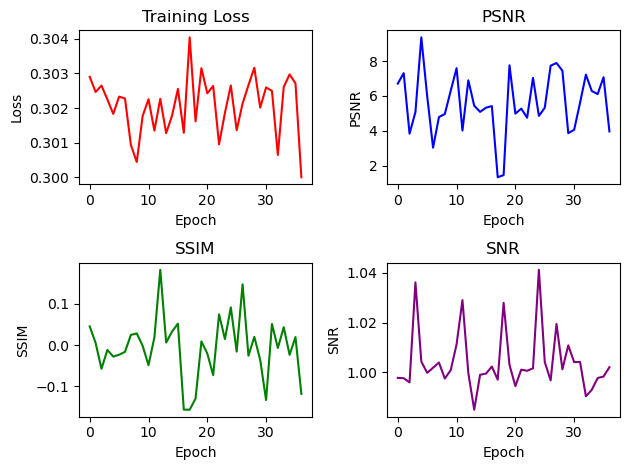

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 357s 123ms/step - loss: 0.3022 - psnr: 5.5024 - snr: 1.0016 - ssim: 0.0069 - val_loss: 0.2972 - val_psnr: 12.2622 - val_snr: 1.0026 - val_ssim: 0.1589
Epoch 38/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.3022 - psnr: 5.4655 - snr: 1.0016 - ssim: 0.0070

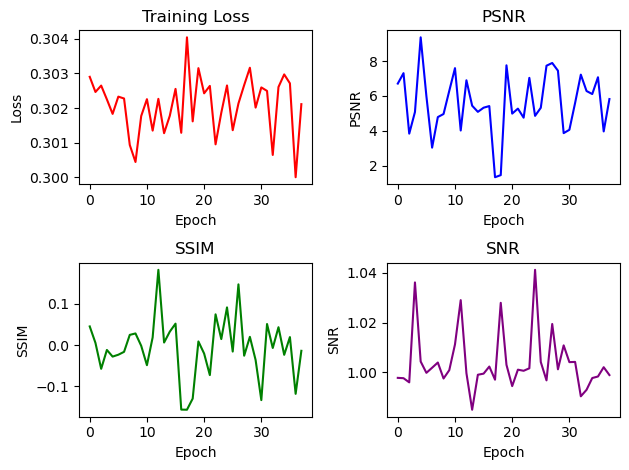

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 364s 126ms/step - loss: 0.3022 - psnr: 5.4657 - snr: 1.0016 - ssim: 0.0070 - val_loss: 0.3055 - val_psnr: 5.2697 - val_snr: 1.0026 - val_ssim: 0.0137
Epoch 39/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.2997 - psnr: 5.4700 - snr: 1.0016 - ssim: 0.0073

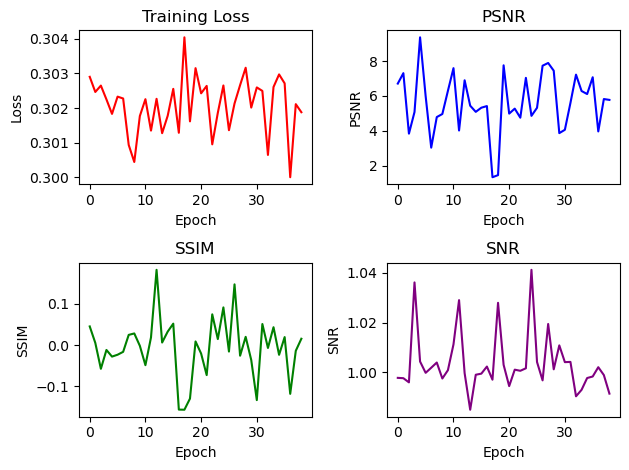

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 361s 124ms/step - loss: 0.2997 - psnr: 5.4701 - snr: 1.0016 - ssim: 0.0073 - val_loss: 0.3019 - val_psnr: 4.7222 - val_snr: 1.0035 - val_ssim: 0.0087
Epoch 40/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.3016 - psnr: 5.4703 - snr: 1.0013 - ssim: 0.0077

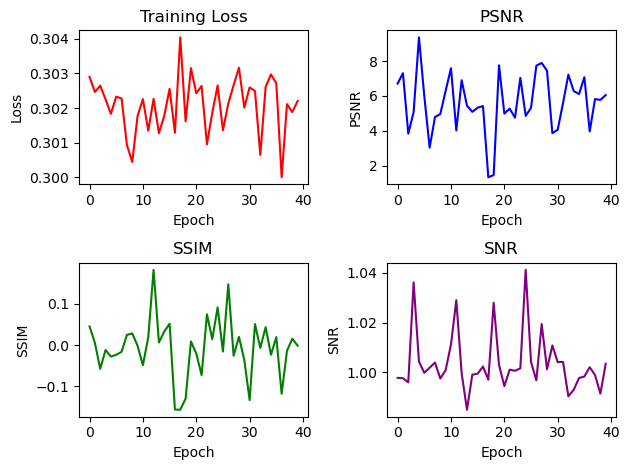

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 360s 124ms/step - loss: 0.3016 - psnr: 5.4705 - snr: 1.0013 - ssim: 0.0077 - val_loss: 0.3023 - val_psnr: 5.3084 - val_snr: 1.0014 - val_ssim: -0.0690
Epoch 41/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.2985 - psnr: 5.4693 - snr: 1.0014 - ssim: 0.0073

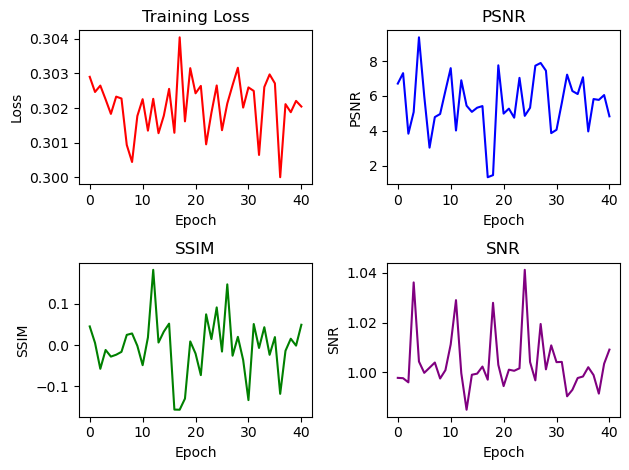

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 360s 124ms/step - loss: 0.2985 - psnr: 5.4691 - snr: 1.0014 - ssim: 0.0073 - val_loss: 0.3070 - val_psnr: 4.8793 - val_snr: 0.9972 - val_ssim: 0.0198
Epoch 42/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.3005 - psnr: 5.4647 - snr: 1.0017 - ssim: 0.0092

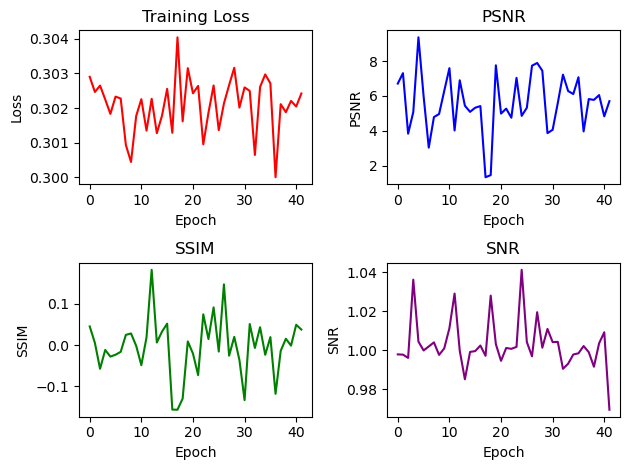

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 362s 125ms/step - loss: 0.3005 - psnr: 5.4648 - snr: 1.0017 - ssim: 0.0092 - val_loss: 0.3034 - val_psnr: 6.3249 - val_snr: 0.9960 - val_ssim: -0.0049
Epoch 43/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.3049 - psnr: 5.4906 - snr: 1.0017 - ssim: 0.0087

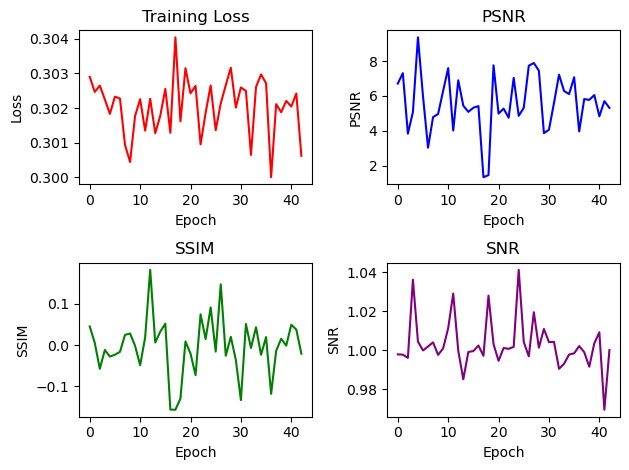

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 362s 125ms/step - loss: 0.3049 - psnr: 5.4905 - snr: 1.0017 - ssim: 0.0087 - val_loss: 0.3044 - val_psnr: 5.1538 - val_snr: 1.0057 - val_ssim: -0.0613
Epoch 44/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.3016 - psnr: 5.4887 - snr: 1.0013 - ssim: 0.0079

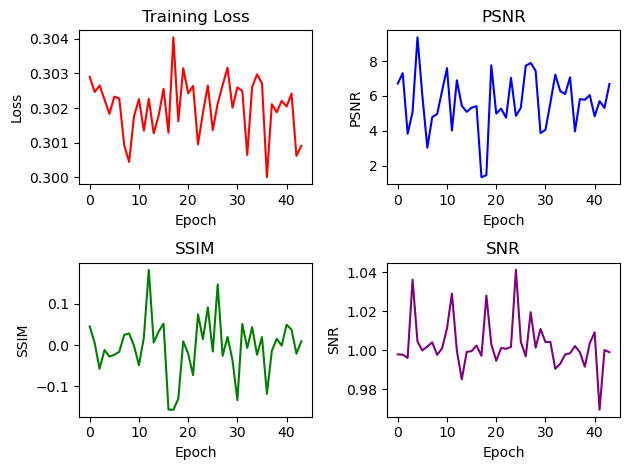

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 362s 125ms/step - loss: 0.3016 - psnr: 5.4891 - snr: 1.0013 - ssim: 0.0079 - val_loss: 0.3017 - val_psnr: 5.1021 - val_snr: 0.9949 - val_ssim: 0.0273
Epoch 45/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.3048 - psnr: 5.4734 - snr: 1.0018 - ssim: 0.0070

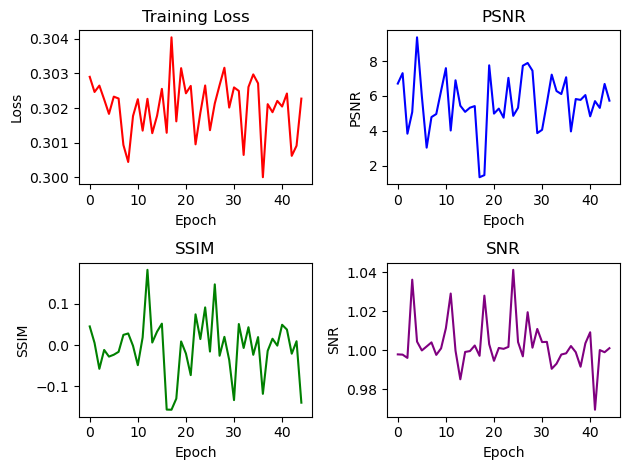

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 362s 125ms/step - loss: 0.3048 - psnr: 5.4735 - snr: 1.0018 - ssim: 0.0070 - val_loss: 0.3003 - val_psnr: 4.2901 - val_snr: 1.0003 - val_ssim: 0.0693
Epoch 46/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.2966 - psnr: 5.4674 - snr: 1.0013 - ssim: 0.0069

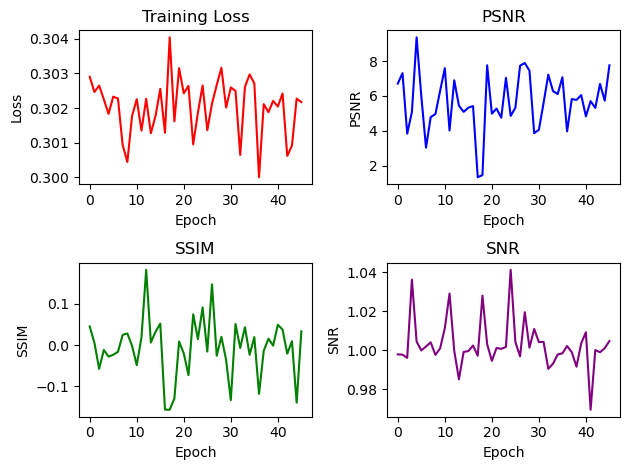

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 362s 125ms/step - loss: 0.2966 - psnr: 5.4682 - snr: 1.0013 - ssim: 0.0069 - val_loss: 0.3003 - val_psnr: 5.5492 - val_snr: 0.9948 - val_ssim: 0.1156
Epoch 47/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.2999 - psnr: 5.4620 - snr: 1.0014 - ssim: 0.0078

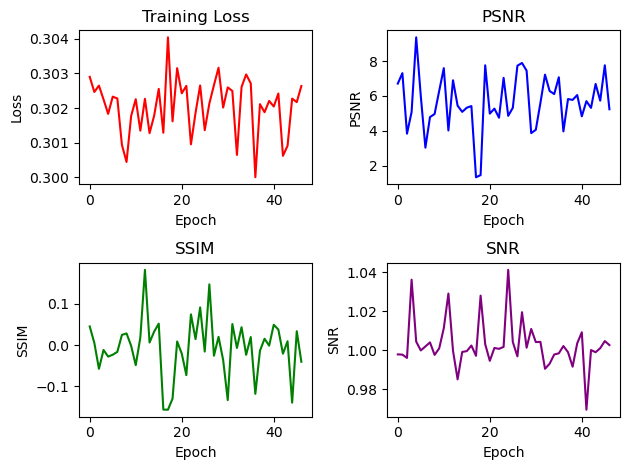

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 369s 127ms/step - loss: 0.2999 - psnr: 5.4619 - snr: 1.0014 - ssim: 0.0078 - val_loss: 0.2917 - val_psnr: 6.6740 - val_snr: 1.0223 - val_ssim: 0.0237
Epoch 48/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.3019 - psnr: 5.4926 - snr: 1.0016 - ssim: 0.0080

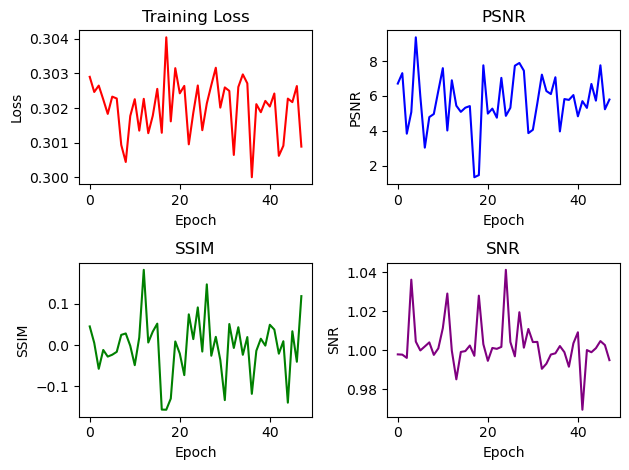

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 367s 126ms/step - loss: 0.3019 - psnr: 5.4927 - snr: 1.0016 - ssim: 0.0081 - val_loss: 0.3049 - val_psnr: 4.6002 - val_snr: 1.0027 - val_ssim: 0.0404
Epoch 49/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.3025 - psnr: 5.4694 - snr: 1.0017 - ssim: 0.0090

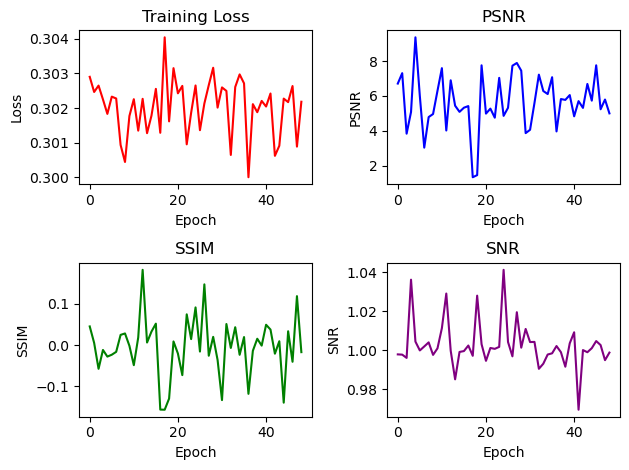

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 365s 126ms/step - loss: 0.3025 - psnr: 5.4693 - snr: 1.0017 - ssim: 0.0090 - val_loss: 0.3009 - val_psnr: 4.5037 - val_snr: 0.9944 - val_ssim: 0.0346
Epoch 50/50
2840/2840 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.3011 - psnr: 5.4661 - snr: 1.0016 - ssim: 0.0090

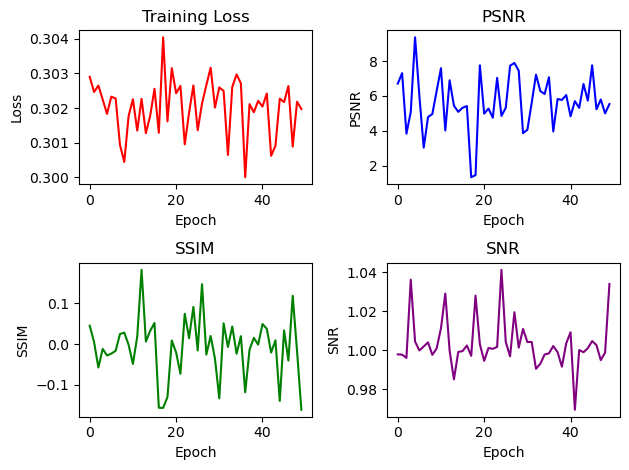

2840/2840 ━━━━━━━━━━━━━━━━━━━━ 366s 126ms/step - loss: 0.3011 - psnr: 5.4661 - snr: 1.0016 - ssim: 0.0089 - val_loss: 0.3030 - val_psnr: 4.7593 - val_snr: 1.0086 - val_ssim: -0.0042


In [25]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint_callback, realtime_plotting_callback]
)